In [2]:
import os 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt 
import pylab
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
class Augment:
    def __init__(self, config):
        self.mfcc_data = []
        self.bands = 128
        self.frames = 128
        self.counts = {
            "english": 0,
            "hindi": 0,
            "mandarin": 0,
            "tagalog": 0,
            "other": 0
        }

        self.pitch_shift_count = config.get("pitch_shift_count",0) #should be even
        self.gaussian_noise_count = config.get("gaussian_noise_count",0)
        self.gaussian_noise_stdev = config.get("gaussian_noise_stdev",1) #1 dB
        self.save_npys = config.get("save_npys",False)
        self.save_jpgs = config.get("save_jpgs",True)
        self.duration = config.get("duration", 1)
        self.sr = config.get("sr", 22050)

        self.abs_dir = "/content/drive/My Drive/APS360 Group Project"

        self.splits = ("train", "validation", "test")
        self.labels = ("english", "hindi", "mandarin", "tagalog")

        # where the raw audio files are located
        self.audio_files_dir = "audio_split"
        self.audio_path = os.path.join(self.abs_dir, self.audio_files_dir)

        # where to save the generated dataset
        self.name = self.name_generator()
        self.save_path = os.path.join(self.abs_dir, self.name)

    def create_dataset(self):
        for split in self.splits:
            for label in self.labels:
                sub_dir = ("%s/%s"%(split,label))
                print("Processing %s..."%(sub_dir))
                self.create_mfccs(sub_dir)

    def name_generator(self):
        return("mfcc_dur_%s_psc_%d_gnc_%d_std_%d"%(self.duration,self.pitch_shift_count,self.gaussian_noise_count, self.gaussian_noise_stdev))

    def windows(self,data,window_size):
        start = 0 
        yield start, start + window_size
        start += (window_size / 2)

    def pitch_shifter(self, clip, sr):
        boundary = int(self.pitch_shift_count/2)
        pitch_shifted_mfccs = []
        for i in range(-boundary, boundary+1):
            if i != 0:
                shifted_clip = librosa.effects.pitch_shift(clip, sr, i)
                pitch_shifted_mfccs.append(self.get_MFCC(shifted_clip))
        return pitch_shifted_mfccs

    def gaussian_noiser(self, mfcc):
        np.random.seed(1)
        gaussian_noised_mfccs = []
        for i in range(0, self.gaussian_noise_count):
            noise = np.random.normal(0,self.gaussian_noise_stdev,mfcc.shape)
            gaussian_noised_mfccs.append(noise + mfcc)
        return gaussian_noised_mfccs

    def get_MFCC(self,speech):
        mfcc = librosa.feature.melspectrogram(speech) 
        logspec = librosa.amplitude_to_db(mfcc)
        return logspec

    def resize_mfcc(self,mfcc):
        resized_mfcc = librosa.util.fix_length(mfcc, self.bands, axis=1)
        resized_mfcc = np.vstack((np.zeros((0, self.bands)), resized_mfcc))
        return resized_mfcc
        
    def save_data(self,data,sub_dir, name_only):
                
        if self.save_npys: # deprecated, but still usable
            new_filename_npy = name_only + '.npy'
            path_npy = [self.save_path,sub_dir,new_filename_npy]
            save_path_npy = os.path.join(*path_npy)
            try:
                np.save(save_path_npy,data)
            except FileNotFoundError:
                save_dir = os.path.join(self.save_path, sub_dir)
                os.makedirs(save_dir)
                np.save(save_path_npy,data)

        if self.save_jpgs:
            new_filename_jpg = name_only + '.jpg'
            path_jpg = [self.save_path,sub_dir,new_filename_jpg]
            save_path_jpg = os.path.join(*path_jpg)
            save_dir_path_jpg = os.path.join(self.save_path, sub_dir)
            pylab.axis('off')
            pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
            librosa.display.specshow(data)
            try:
                pylab.savefig(save_path_jpg, bbox_inches=None, pad_inches=0)
                pylab.close()
            except FileNotFoundError:
                save_dir = os.path.join(self.save_path, sub_dir)
                os.makedirs(save_dir)
                pylab.savefig(save_path_jpg, bbox_inches=None, pad_inches=0)
                pylab.close()
            print("Saved %s"%save_path_jpg)

        return True 
    
    def uniform_clip_split(self, sub_dir, file_name):
        path = [self.audio_path,sub_dir,file_name] 
        file_path = os.path.join(*path)
        print(file_path)

        # check if this is train, val, or test
        split, language = sub_dir.split("/")

        name_only = file_name.split(".mp3")[0]
        speech,s = librosa.load(file_path, self.sr)
        num_frames = int(self.duration*s)
        for i in range(0, int(len(speech)/num_frames)):
            if language in self.counts.keys():
                num = self.counts[language]
                self.counts[language] += 1
            else:
                num = self.counts["other"]
                self.counts["other"] += 1 

            start = i*num_frames
            end = start + num_frames 
            if (len(speech[start:end]) == num_frames):
                clip = speech[start:end]
                clip_name = name_only + "_clip" + str(num)

                # generate and save unaltered MFCC
                raw_mfcc = self.get_MFCC(clip)
                print("Shape:",raw_mfcc.shape)
                self.save_data(raw_mfcc,sub_dir,clip_name)

                if split == "train":
                    # generate and save noisy, unshifted MFCCs (only for training)
                    noisy_mfccs = self.gaussian_noiser(raw_mfcc)
                    for i, noisy_mfcc in enumerate(noisy_mfccs):
                        self.save_data(noisy_mfcc,sub_dir,(clip_name+"_noisy%d"%(i)))

                    # generate and save pitch-shifted MFCCs - both noisy and non-noisy
                    shifted_mfccs = self.pitch_shifter(clip,self.sr)
                    lowest_shift = -1*int(self.pitch_shift_count/2)
                    for i, shifted_mfcc in enumerate(shifted_mfccs):
                        shift = lowest_shift + i
                        shifted_name = clip_name+("_shifted%d"%(shift))
                        self.save_data(shifted_mfcc,sub_dir,shifted_name)

                        noisy_shifted_mfccs = self.gaussian_noiser(shifted_mfcc)
                        for j, noisy_shifted_mfcc in enumerate(noisy_shifted_mfccs):
                            noisy_shifted_name = shifted_name + ("_noisy%d"%j)
                            self.save_data(noisy_shifted_mfcc,  sub_dir, shifted_name)

    def create_mfccs(self, sub_dir):
        for file_name in os.listdir(os.path.join(self.audio_path,sub_dir)):
            print(file_name)
            self.uniform_clip_split(sub_dir,file_name)
        return True

Processing train/english...
english105.mp3
/content/drive/My Drive/APS360 Group Project/audio_split/train/english/english105.mp3
Shape: (128, 44)
Saved /content/drive/My Drive/APS360 Group Project/mfcc_dur_1_psc_4_gnc_2_std_1/train/english/english105_clip0.jpg
Saved /content/drive/My Drive/APS360 Group Project/mfcc_dur_1_psc_4_gnc_2_std_1/train/english/english105_clip0_noisy0.jpg
Saved /content/drive/My Drive/APS360 Group Project/mfcc_dur_1_psc_4_gnc_2_std_1/train/english/english105_clip0_noisy1.jpg
Saved /content/drive/My Drive/APS360 Group Project/mfcc_dur_1_psc_4_gnc_2_std_1/train/english/english105_clip0_shifted-2.jpg
Saved /content/drive/My Drive/APS360 Group Project/mfcc_dur_1_psc_4_gnc_2_std_1/train/english/english105_clip0_shifted-2.jpg
Saved /content/drive/My Drive/APS360 Group Project/mfcc_dur_1_psc_4_gnc_2_std_1/train/english/english105_clip0_shifted-2.jpg
Saved /content/drive/My Drive/APS360 Group Project/mfcc_dur_1_psc_4_gnc_2_std_1/train/english/english105_clip0_shifted-1

KeyboardInterrupt: ignored

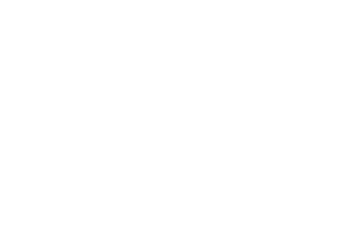

In [10]:
config = {
    "pitch_shift_count": 4,
    "gaussian_noise_count": 2,
    "gaussian_noise_stdev": 1,
    "save_jpgs": True,
    "save_npys": False,
    "duration": 1,
    "sr": 22050
}

data = Augment(config)

data.create_dataset()

In [ ]:
%%shell

pwd
!cd "drive/My Drive/APS360 Group Project"
!pwd

/content
/content
